#Value & Policy Iteration

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import itertools

Our environment consists of a 5x5 grid represented as a series of board[row, col] coordinates.
At each state the agent may  give an action of [left,down,right,up] until it gets to the end of the cliff or falls off.
After each action the agent will receive a reward in the next state.
-1 for an action
-10 if it falls of the cliff. The game ends
+100 if it reaches the end of the cliff. The game ends

A terminal state denotes the ending of a game. In our example it the board state [4,1],[4,2],[4,3],[4,4]


Value iteration:

We will use value iteration to find the most optimal action for each state on the board.  Intuitively, we can express it as the value of (board[4,3],action[down]) as a reward of 100.

The Value function requires multiple iterations to converge:

Policy iteration:
 

In [0]:
# Define our environment and terminal states
board = np.array([
    [-1,-1,-1,-1,-1],
    [-1,-1,-1,-1,-1],
    [-1,-1,-1,-1,-1],
    [-1,-1,-1,-1,-1],
    [-1,-10,-10,-10,100]
])
terminal_states = [-10, 100]

nrow = board.shape[0]  # Number of rows
ncol = board.shape[1]  # Number of columns
nS = nrow * ncol       # Number of states
nA = 4                 # Number of actions

def inc(row, col, a):
  """Defines the possible actions"""
  if a == LEFT:
     col = max(col-1,0)
  elif a == DOWN:
    row = min(row+1,nrow-1)
  elif a == RIGHT:
    col = min(col+1,ncol-1)
  elif a == UP:
    row = max(row-1,0)
  return (row, col)
        
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

In [0]:
def to_s(row, col, ncol):
  """
  Transforms a two dimensional coordinate into a one dimensional coordinate
  """
  return (row*ncol + col)

def create_dict():
  # This function creates a dictionary of dictionaries containing a list with
  # the probability, newstate and reward for each action in each state  
  P = {s : {a : [] for a in range(nA)} for s in range(nS)}  
  for row in range(nrow):
    for col in range(ncol):
      s = to_s(row,col,ncol)
      for a in range(4):
        li = P[s][a]
        content = board[row, col]
        if content in terminal_states:
          li.append((1.0, s, 0))
        else:
          newrow, newcol = inc(row, col, a)
          newcontent = board[newrow, newcol]
          newstate = to_s(newrow, newcol, ncol)
          rew = newcontent
          li.append((1.0, newstate, rew))
  return (P)
P = create_dict()

def step_iteration(board):
  res = np.zeros([nrow, ncol, 5], float)   # Matrix of q values and state values
  pol = np.zeros([nrow, ncol, 4], float)
  gamma = 0.9                              # Discount factor
  eps = 1e-20                              # Arbitrary small positive number to measure when
                                           # the value iteration is almost not changing and we can stop the iterations
  
  for i in range(1000):
    prev_res = np.copy(res)
    for r in range(nrow):
      for c in range(ncol):
        actions = 0
        for a in range(4):
          s = r * 5 + c
          res[r][c][a] = sum([p*(r + gamma * prev_res[s_//ncol][s_%ncol][4]) for p, s_, r in P[s][a]])  # Calculate Q-Values
          res[r][c][4] = max(res[r][c])                                                                 # Update State Value\
        for a in range(4):
          if res[r][c][a] == res[r][c][4]:
            actions += 1
        for a in range(4):                                                                              # Update Policy
          if res[r][c][a] == res[r][c][4] and actions != 0:
            pol[r][c][a] = 1.0/actions
          else:
            pol[r][c][a] = 0.0
    yield (res,pol,0)
    if (np.sum(np.fabs(prev_res - res)) <= eps):                                                        # Condition to stop
      yield (res,pol,i+1)
      break
  while True:
    yield (res,pol,i+1)
step = step_iteration(board)


In [0]:
# Value / Policy gradient graph
def plot_grid(vm, pm, cmap=None):
    fig, axs = plt.subplots(vm.shape[0], vm.shape[1], sharex='col', sharey='row', figsize=(vm.shape[0]*2, vm.shape[1]*2))
    # Create a subplot for each state.
    number_of_actions = vm.shape[2]
    v_min = np.min(vm)
    v_range = np.max(vm) - v_min
    
    y_width = vm.shape[0]
    x_width = vm.shape[1]
    
    def normalize_color_range(value):
      # Normalizes a cells float value to rgb values [r,g,b]
      newvalue = (((value - v_min) * 255) / v_range)
      if np.isnan(newvalue):
        newvalue = 0
      else:
        newvalue = (int(newvalue) - 255) * -1
      return([newvalue,newvalue,255])
    
    for y in range(vm.shape[0]):
      axs[y][0].set_ylabel(y, rotation=0)             # Set y axis label
      for x in range(vm.shape[1]):
        matrix = np.array([                           # Transform 1,5 array of values to 3x3 array
            [0,vm[y,x,3],0],
            [vm[y,x,0],vm[y,x,4],vm[y,x,2]],
            [0,vm[y,x,1],0]
        ])
        policy = np.array([                           # Transform 1,5 array of values to 3x3 array
            [0,pm[y,x,3],0],
            [pm[y,x,0],0,pm[y,x,2]],
            [0,pm[y,x,1],0]
        ])
        colorgrid=np.array([                          # Transform array of values to 3x3 RGB array
            [[0,0,0],normalize_color_range(vm[y,x,3]),[0,0,0]],
            [normalize_color_range(vm[y,x,0]),normalize_color_range(vm[y,x,4]),normalize_color_range(vm[y,x,2])],
            [[0,0,0],normalize_color_range(vm[y,x,1]),[0,0,0]]
        ])
        axs[y][x].imshow(colorgrid)                               # Plot color for current subplot
        for j in range(matrix.shape[0]):
          for k in range(matrix.shape[1]):
            if j == 1 or k == 1:
              if j==1 and k ==1:
                axs[y][x].text(k,j,"{:0.0f}".format(matrix[j,k]), # Plot value
                             horizontalalignment="center",
                             verticalalignment="center")
              else:
                axs[y][x].text(k,j,"{:0.0f}".format(matrix[j,k])+"\n"+"{0:3.2f}".format(policy[j,k]),
                             horizontalalignment="center",
                             verticalalignment="center")          # Plot value | probablity
        axs[y][x].set_yticks([])                                  # Remove ticks
        axs[y][x].set_xticks([])
        axs[vm.shape[0]-1][x].set_xlabel(x, rotation=0)           # Set x label
    plt.tight_layout()
    plt.show()

In [0]:
# Press the play button to see the value and policy of each state.
def next_step():
    value_matrix, policy_matrix, finished = next(step)
    if finished:
      print ('Policy-iteration converged at iteration %d.' %(finished))
    plot_grid(value_matrix, policy_matrix)

Each cell represents a unique state on our 5x5 Board.

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vSlBoN6AeYK0rd_5aFWX9S5dOAEkj1HwSM40M0TwCy28t0xxm7Btp5igdtRehXHXLDSD2oZs8E1ljaY/pub?w=269&h=174)

State Value of Board[3,4]

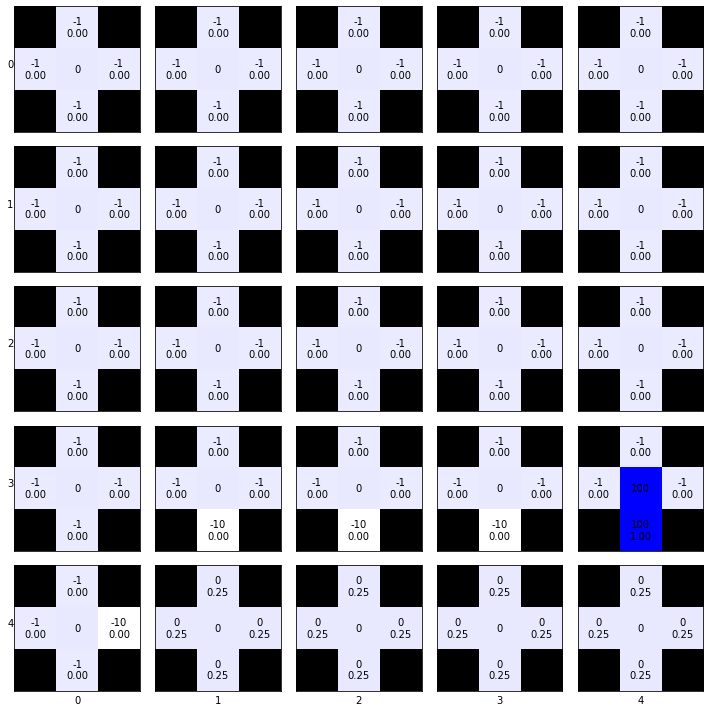

In [6]:
#Press Play to for one Value and Policy iteration
next_step()

In [0]:
# Reset our value and policy
P = create_dict()
step = step_iteration(board)

Policy-iteration converged at iteration 10.


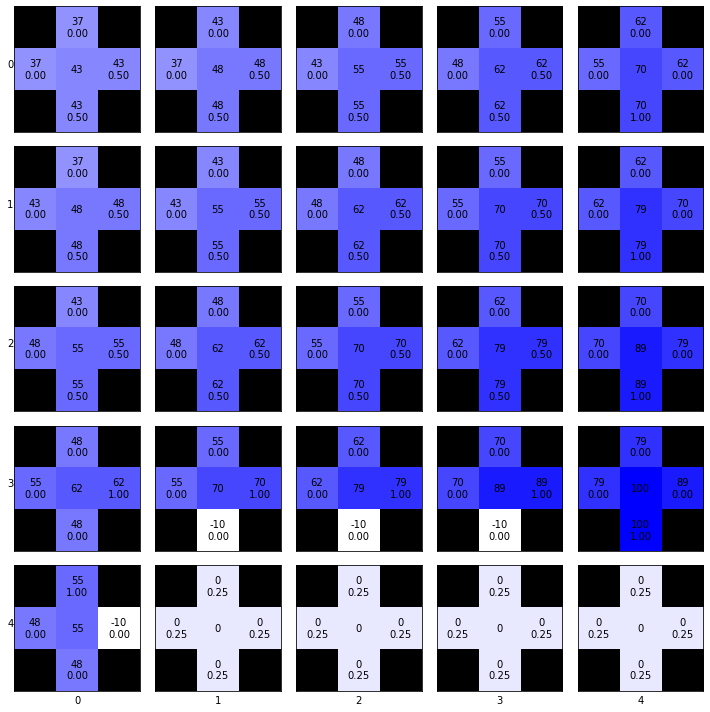

In [8]:
# Iterate until our value and policy converges

# Iterate and plot grid
def iterate_values():
  finished = 0
  while not finished:
    value_matrix, policy_matrix, finished = next(step)
  return (value_matrix,policy_matrix, finished)
value_matrix, policy_matrix, finished = iterate_values()
print ('Policy-iteration converged at iteration %d.' %(finished))
plot_grid(value_matrix, policy_matrix)